 ## Este notebook visa testar diversos encoders para as imagens de escâner
 
As imagens já deverão estar "tratadas"/editadas( "tratar" em termos de retirar lixo, como espaço vazio, carreta, caminhão, etc) para deixar somente as bordas do contêiner e seu conteúdo.

 ## Problema a resolver: busca de imagens

Formulação:

Aqui, o objetivo é testar encoders para obter uma representação comprimida das imagens que permita montar um banco de dados para busca de imagens similares. Lembrando que o esperado apenas para ALFSTS são 3000 imagens dia. Num universo de apenas 5 anos, são 3.000x365x5 = 5,5 milhões.

Cada imagem, mesmo que seja apenas um Thumbnail de 150x80 pixels, ocuparia uma média de pouco mais de 2-3KB numa compressão de arquivo JPEG, ou um total de 12-16GB de RAM. No formato matriz, são 150x80x4bytes ou 48KB, ou até 200GB de RAM. 

Solução testada neste notebook:

Utilizar autoencoders para aprender uma representação de poucos números float32 (de 100 a 500) ou até 4 vezes mais "bits" que possam descrever a imagem com o intuito de indexação por comparação (distância Euclidiana ou Chi-Square para os floats, Hamming para os bits) na busca de imagens similares. Assim, precisaremos "apenas" de 1GB a 4GB de RAM para montar a matriz ordenada na memória.

Importante ter em mente que a busca é uma comparação one X all (um contra todos), ou seja, uma única imagem buscada será comparada, todas as vezes, com o banco todo. Portanto, não é um caso de agrupamento/cluster como kNN, até porque a busca é sempre relativa à imagem buscada. Também não é uma busca possível de ser feita em banco de dados, pois não há como indexar ANTES de calcular a distância de cada número ou bit.

Algoritmos de agrupamento podem seu úteis caso o BD fique grande demais, mas aí o ideal é um algoritmo de agrupamento simples, um cálculo, por exemplo de "densidade de imagem", e criar n limites (thresholds) de densidade para criar n bancos separados. Aí aplica-se o algoritmo na imagem buscada e determina-se o banco onde esta será buscada. Caso a imagem esteja muito próxima de um threshold, busca-se em dois bancos simultâneos.


In [1]:
from __future__ import division, print_function, absolute_import

import numpy as np
import matplotlib.pyplot as plt
import tflearn
import glob
import os
from PIL import Image

home = '/home/ivan/Área de Trabalho/ajna/amostras/stamps/'
dest = os.path.join(home, 'resize/')
size = (256, 120)

In [2]:
3000*365*5

5475000

## Redimensionamento de imagens - rodar somente se necessário

In [ ]:
#for file in glob.glob(os.path.join(home,'*.jpg')):
    im = Image.open(file)
    im2 = im.resize(size, Image.ANTIALIAS)
    im2.save(os.path.join(dest, file[-15:]), "JPEG")


## Carrega imagens transformando em matriz

(652, 30720)
80117872


/usr/lib/python3/dist-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


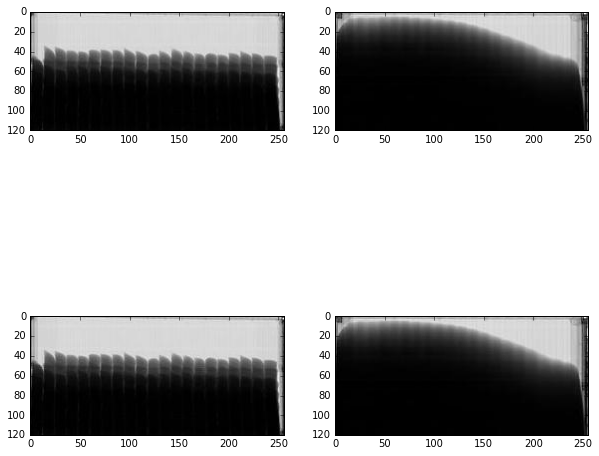

In [3]:
%matplotlib inline
from sys import getsizeof

input = size[0]*size[1]
numarquivos = len([name for name in os.listdir(dest) if name.endswith('jpg')])

X = np.ndarray(shape=(numarquivos, input), dtype=np.float32)
print(X.shape)

Xorig = np.ndarray(shape=(numarquivos, size[1], size[0]), dtype=np.float32)

cont = 0
for file in glob.glob(os.path.join(dest,'*.jpg')):
    im = Image.open(file)
    Xorig[cont] = np.asarray(im)
    X[cont] = np.asarray(im).reshape(input)
    cont +=1

print(getsizeof(X))
f, a = plt.subplots(2, 2, figsize=(10, 10))
for i in range(2):
    a[0][i].imshow(np.reshape(X[i], (size[1], size[0])), cmap='gray')
    a[1][i].imshow(np.reshape(Xorig[i], (size[1], size[0])), cmap='gray')
f.show()
plt.draw()

**Normalizar entre 0 e 1 para facilitar aprendizado**

In [4]:
X = X / 255
X

array([[ 0.22352941,  0.28235295,  0.25882354, ...,  0.23921569,
         0.12941177,  0.05098039],
       [ 0.15686275,  0.3882353 ,  0.50980395, ...,  0.07058824,
         0.36470589,  0.28235295],
       [ 0.43529412,  0.4509804 ,  0.85882354, ...,  0.03137255,
         0.05490196,  0.03529412],
       ..., 
       [ 0.36078432,  0.3137255 ,  0.27450982, ...,  0.12156863,
         0.13725491,  0.07058824],
       [ 0.42352942,  0.33725491,  0.63137257, ...,  0.05098039,
         0.12156863,  0.42745098],
       [ 0.31764707,  0.43921569,  0.60392159, ...,  0.05490196,
         0.01176471,  0.02352941]], dtype=float32)

## Monta encoder plano (fully connected)

In [5]:
# Building the encoder
print(input)
print(input*300)
print(300*100)
encoder = tflearn.input_data(shape=[None, input])
encoder = tflearn.fully_connected(encoder, 400)
encoder = tflearn.fully_connected(encoder, 200)
# Building the decoder
decoder = tflearn.fully_connected(encoder, 400)
decoder = tflearn.fully_connected(decoder, input, activation='sigmoid')

# Regression, with mean square error
net = tflearn.regression(decoder, optimizer='adam', learning_rate=0.001,
                         loss='mean_square', metric=None)
model = tflearn.DNN(net, tensorboard_verbose=0)

30720
9216000
30000


In [6]:
print("Total de parâmetros:")
print(input*2+input*300*2+100*300)

Total de parâmetros:
18523440


In [7]:
X.shape

(652, 30720)

In [8]:
print("Tamanho da representação:")
print(encoder.shape)

Tamanho da representação:
(?, 200)


In [9]:
# Training the auto encoder

model.fit(X[:639], X[:639], n_epoch=100, run_id="auto_encoder", batch_size=80)


Training Step: 799  | total loss: 0.00774 | time: 1.583s
| Adam | epoch: 100 | loss: 0.00774 -- iter: 560/639
Training Step: 800  | total loss: 0.00766 | time: 1.812s
| Adam | epoch: 100 | loss: 0.00766 -- iter: 639/639
--



Test encoding of X[0]:
[ 0.22352941  0.28235295  0.25882354 ...,  0.23921569  0.12941177
  0.05098039]
[[4.897933483123779, -1.7184706926345825, 0.6896719932556152, -0.5314728617668152, -2.1172380447387695, -3.497640371322632, -4.854184150695801, -0.8620917201042175, 6.543034076690674, -3.8470911979675293, 4.942697048187256, 1.2323927879333496, -1.4846917390823364, -1.8519268035888672, -1.5312796831130981, -1.8031505346298218, -0.954465389251709, -3.777325391769409, 0.2997204065322876, -15.368456840515137, 0.47658011317253113, 0.7802581191062927, -5.97224235534668, -5.377692699432373, 1.4079005718231201, 0.12082749605178833, -0.3064177930355072, 5.270274639129639, -0.904893159866333, -3.2340362071990967, -1.8712007999420166, -3.0514564514160156, -1.0738955736160278, -0.2446984201669693, -0.7698429822921753, 0.8378614187240601, 5.566705703735352, -1.467760682106018, -0.43396565318107605, -1.9406381845474243, -4.122467517852783, 4.242256164550781, 5.035825252532959, 5.948013782501221, 4

/usr/lib/python3/dist-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


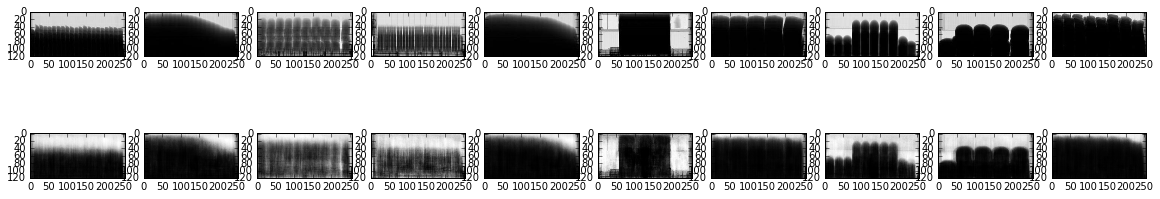

In [10]:
%matplotlib inline
# Encoding X[0] for test
print("\nTest encoding of X[0]:")
# New model, re-using the same session, for weights sharing
encoding_model = tflearn.DNN(encoder, session=model.session)
print(X[0])
print(encoding_model.predict([X[0]]))

# Testing the image reconstruction on new data (test set)
print("\nVisualizing results after being encoded and decoded:")
#testX = tflearn.data_utils.shuffle(testX)[0]
# Applying encode and decode over test set
encode_decode = model.predict(X[0:10])
# Compare original images with their reconstructions
f, a = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    #temp = [[ii, ii] for ii in list(X[i])]
    a[0][i].imshow(np.reshape(X[i], (size[1], size[0])), cmap='gray')
    #temp = [[ii, ii] for ii in list(encode_decode[i])]
    a[1][i].imshow(np.reshape(encode_decode[i], (size[1], size[0])), cmap='gray')
f.show()
plt.draw()


## Montar Encoder convolucional

In [5]:
import tensorflow as tf

inputs_ = tf.placeholder(tf.float32, (None, size[1], size[0], 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, size[1], size[0], 1), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 32, (3,3), padding='same', activation=tf.nn.relu)
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
conv2 = tf.layers.conv2d(maxpool1, 16, (3,3), padding='same', activation=tf.nn.relu)
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
conv3 = tf.layers.conv2d(maxpool2, 16, (3,3), padding='same', activation=tf.nn.relu)
maxpool3 = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
conv31 = tf.layers.conv2d(maxpool3, 8, (3,3), padding='same', activation=tf.nn.relu)
maxpool31 = tf.layers.max_pooling2d(conv31, (2,2), (2,2), padding='same')
conv32 = tf.layers.conv2d(maxpool31, 8, (3,3), padding='same', activation=tf.nn.relu)
encoded = tf.layers.max_pooling2d(conv32, (2,2), (2,2), padding='same')

### Decoder
upsample00 = tf.image.resize_nearest_neighbor(encoded, (int(size[1]/16),int(size[0]/16)))
conv34 = tf.layers.conv2d(upsample00, 8, (3,3), padding='same', activation=tf.nn.relu)
upsample0 = tf.image.resize_nearest_neighbor(encoded, (int(size[1]/8),int(size[0]/8)))
conv34 = tf.layers.conv2d(upsample0, 8, (3,3), padding='same', activation=tf.nn.relu)
upsample1 = tf.image.resize_nearest_neighbor(encoded, (int(size[1]/4),int(size[0]/4)))
conv4 = tf.layers.conv2d(upsample1, 8, (3,3), padding='same', activation=tf.nn.relu)
upsample2 = tf.image.resize_nearest_neighbor(conv4, (int(size[1]/2),int(size[0]/2)))
conv5 = tf.layers.conv2d(upsample2, 8, (3,3), padding='same', activation=tf.nn.relu)
upsample3 = tf.image.resize_nearest_neighbor(conv5, (int(size[1]),int(size[0])))
conv6 = tf.layers.conv2d(upsample3, 16, (3,3), padding='same', activation=tf.nn.relu)
logits = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=None)

decoded = tf.nn.sigmoid(logits, name='decoded')

loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(0.001).minimize(cost)

In [6]:
maxpool1.shape

TensorShape([Dimension(None), Dimension(60), Dimension(128), Dimension(32)])

In [7]:
maxpool2.shape

TensorShape([Dimension(None), Dimension(30), Dimension(64), Dimension(16)])

In [8]:
maxpool3.shape

TensorShape([Dimension(None), Dimension(15), Dimension(32), Dimension(16)])

In [9]:
maxpool31.shape

TensorShape([Dimension(None), Dimension(8), Dimension(16), Dimension(8)])

In [10]:
encoded.shape

TensorShape([Dimension(None), Dimension(4), Dimension(8), Dimension(8)])

 ## Conforme abaixo, a rede convolucional usa muito menos pesos, mas é mais difícil conseguir uma representação tão condensada

Por outro lado, a rede convolucional tende a ter maior invariância quanto à posição dos objetos. Por exemplo, imagine-se um contêiner vazio, um contêiner com apenas um pallet à esquerda e  um contêiner com apenas um pallet à direita.

Para a rede plana, a tendência é que ela considere o vazio mais diferente do que os dois com apenas um pallet. Já na rede convolucional, espera-se que ela "diga" que os contêineres com apenas um pallet cada são mais parecidos entre si.

Assim, nas imagens A, B, C, D e E abaixo (caixa pequena à esquerda, caixa grande à esquerda, caixa pequena à direita, caixa grande à direita, vazio), o ideal é que uma procura pela imagem "A" retornasse (A, C, B, D, E ou A, C, E, D, D). Entretanto numa busca ou comparação plana/sequencial ou qualquer algoritmo de comparação de pontos da imagem o esperado seria A, B, E, C, D. As imagens F e G também estão apenas "espelhadas", mas a tendência é que algoritmos de comparação de imagens a considerem mais diferentes entre si do que entre elas e um vazio. Vamos carregar estas imagens e testar nossos encoders.

 ## A ![Imagem A](imgnotebook/exemplocaixa1.png)
 ## B ![Imagem B](imgnotebook/exemplocaixa2.png)
 ## C ![Imagem C](imgnotebook/exemplocaixa1espelhado.png)
 ## D ![Imagem D](imgnotebook/exemplocaixa2espelhado.png)
 ## E ![Imagem E](imgnotebook/exemplovazio.png)
 ## F ![Imagem F](imgnotebook/exemplocirculo.png)
 ## G ![Imagem G](imgnotebook/exemplocirculoespelhado.png)

In [11]:
print("Tamanho do encoder")
print(encoded.shape[1]*encoded.shape[2]*encoded.shape[3])

Tamanho do encoder
256


In [12]:
sess = tf.Session()
epochs = 100
batch_size = 217
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(X.shape[0]//batch_size):
        batch = X[ii:(ii+1)*batch_size]
        imgs = batch[0].reshape((-1, size[1], size[0], 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})
        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/100... Training loss: 0.6941
Epoch: 1/100... Training loss: 0.6919
Epoch: 1/100... Training loss: 0.6920
Epoch: 2/100... Training loss: 0.6913
Epoch: 2/100... Training loss: 0.6874
Epoch: 2/100... Training loss: 0.6891
Epoch: 3/100... Training loss: 0.6875
Epoch: 3/100... Training loss: 0.6783
Epoch: 3/100... Training loss: 0.6824
Epoch: 4/100... Training loss: 0.6782
Epoch: 4/100... Training loss: 0.6610
Epoch: 4/100... Training loss: 0.6692
Epoch: 5/100... Training loss: 0.6624
Epoch: 5/100... Training loss: 0.6313
Epoch: 5/100... Training loss: 0.6504
Epoch: 6/100... Training loss: 0.6359
Epoch: 6/100... Training loss: 0.5904
Epoch: 6/100... Training loss: 0.6310
Epoch: 7/100... Training loss: 0.5894
Epoch: 7/100... Training loss: 0.5491
Epoch: 7/100... Training loss: 0.6116
Epoch: 8/100... Training loss: 0.5223
Epoch: 8/100... Training loss: 0.5096
Epoch: 8/100... Training loss: 0.6130
Epoch: 9/100... Training loss: 0.4597
Epoch: 9/100... Training loss: 0.4678
Epoch: 9/100

Epoch: 72/100... Training loss: 0.6008
Epoch: 73/100... Training loss: 0.3223
Epoch: 73/100... Training loss: 0.2584
Epoch: 73/100... Training loss: 0.6003
Epoch: 74/100... Training loss: 0.3220
Epoch: 74/100... Training loss: 0.2598
Epoch: 74/100... Training loss: 0.6052
Epoch: 75/100... Training loss: 0.3218
Epoch: 75/100... Training loss: 0.2583
Epoch: 75/100... Training loss: 0.6047
Epoch: 76/100... Training loss: 0.3231
Epoch: 76/100... Training loss: 0.2597
Epoch: 76/100... Training loss: 0.6087
Epoch: 77/100... Training loss: 0.3219
Epoch: 77/100... Training loss: 0.2574
Epoch: 77/100... Training loss: 0.6024
Epoch: 78/100... Training loss: 0.3260
Epoch: 78/100... Training loss: 0.2574
Epoch: 78/100... Training loss: 0.6011
Epoch: 79/100... Training loss: 0.3222
Epoch: 79/100... Training loss: 0.2576
Epoch: 79/100... Training loss: 0.5957
Epoch: 80/100... Training loss: 0.3242
Epoch: 80/100... Training loss: 0.2573
Epoch: 80/100... Training loss: 0.5954
Epoch: 81/100... Training

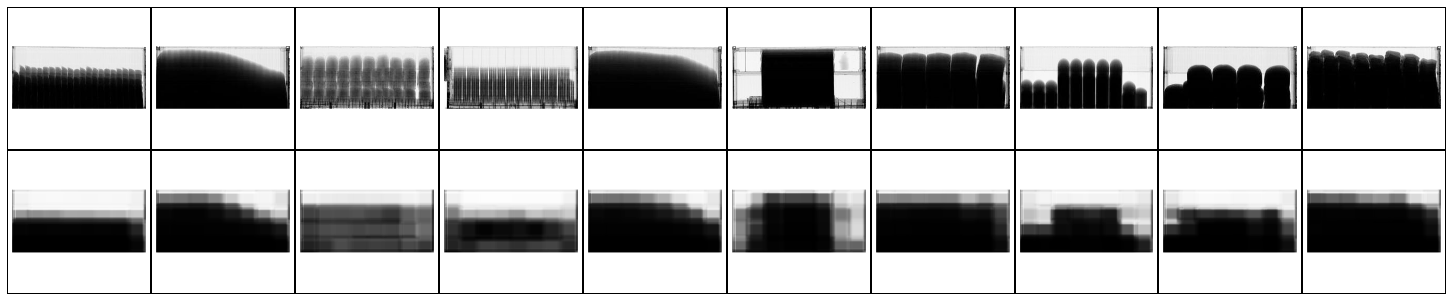

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = X[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, size[1], size[0], 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((size[1], size[0])), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
fig.tight_layout(pad=0.1)

 ## Usar informações do núcleo dos encoders para testar indexação

 ## Somente as duas células abaixo para a rede convolucional

In [14]:


#Caso não seja possível carregar imagens na memória, será necessário loop anterior para carregar imagens em lote
def gerarEncodedConv(session, encoder, Xtotal, batch_size = 64):
    compressed = np.empty((0, 256))
    for r in range(0, Xtotal.shape[0] // batch_size):
        ind1 = r*batch_size
        ind2 = ind1+batch_size
        if  ind2 > Xtotal.shape[0]:
            ind2 = Xtotal.shape[0] - 1
        Xbatch = Xtotal[ind1:ind2]
        compressedbatch = sess.run([encoder], feed_dict={inputs_: Xbatch.reshape((-1, size[1], size[0], 1))})
        compressed = np.concatenate((compressed, np.array(compressedbatch).reshape(-1, 256)), axis=0)
    return compressed
    
compressed = gerarEncodedConv(sess, encoded, X)
print(compressed)
print(compressed.shape)
print(compressed.nbytes) # Memória que será usada 



[[ 0.          0.          0.23429054 ...,  0.          0.          0.93378377]
 [ 0.76334375  0.          0.20620519 ...,  0.04860488  0.          1.06468618]
 [ 0.14602692  0.          0.11857118 ...,  0.          0.          0.0600929 ]
 ..., 
 [ 0.47598445  0.          0.08701094 ...,  0.          0.          0.60259318]
 [ 0.          0.          0.30167446 ...,  0.          0.          0.82165283]
 [ 0.3960354   0.          0.08694166 ...,  0.          0.          0.44375131]]
(640, 256)
1310720


In [15]:
imgSearch = X[30].reshape((-1, size[1], size[0], 1))
compressedSearch = np.array(sess.run([encoded], feed_dict={inputs_: imgSearch})).reshape(-1, 256)

 ## Somente as duas células abaixo para a rede plana

In [11]:
compressed = encoding_model.predict(X)
print(compressed[:1])

[[4.897931098937988, -1.7184385061264038, 0.6896643042564392, -0.5314891934394836, -2.1172616481781006, -3.4976375102996826, -4.854167938232422, -0.862091600894928, 6.543038845062256, -3.847111701965332, 4.942712783813477, 1.23241126537323, -1.484719157218933, -1.8519151210784912, -1.531277060508728, -1.803162932395935, -0.9544658660888672, -3.777315378189087, 0.2997475564479828, -15.36844539642334, 0.47659188508987427, 0.7802829742431641, -5.972211837768555, -5.377694129943848, 1.4078704118728638, 0.12082909792661667, -0.30642250180244446, 5.270263671875, -0.9048789739608765, -3.2340383529663086, -1.8711689710617065, -3.051447629928589, -1.0738706588745117, -0.2447061538696289, -0.7698476314544678, 0.8378998041152954, 5.566689968109131, -1.4677616357803345, -0.433958500623703, -1.9406193494796753, -4.122460842132568, 4.242218971252441, 5.035819053649902, 5.947988986968994, 4.061657905578613, -6.277484893798828, -0.027040231972932816, -3.0954673290252686, 4.141941547393799, -30.1338062

In [13]:
imgSearch = X[50]
compressedSearch = encoding_model.predict([imgSearch])

 ## Testando indexação, passo a passo...

In [16]:
Y2 = np.array(compressedSearch, dtype=np.float32)
print(Y2.nbytes) #memória que será usada por imagem buscada 

1024


In [17]:
X2 = np.array(compressed, dtype=np.float32)
print(X2.shape[0])
print(X2.nbytes*(1000000/X2.shape[0])/1000000) #memória em MB que será usada na lista de imagens para 1 milhão de imagens

640
1024.0


In [18]:
Delta = X2 - Y2
Delta

array([[-0.72688574,  0.        , -0.00932252, ..., -0.00307127,
         0.        ,  0.01256031],
       [ 0.03645802,  0.        , -0.03740788, ...,  0.04553361,
         0.        ,  0.14346272],
       [-0.58085883,  0.        , -0.12504187, ..., -0.00307127,
         0.        , -0.8611306 ],
       ..., 
       [-0.25090128,  0.        , -0.15660211, ..., -0.00307127,
         0.        , -0.31863028],
       [-0.72688574,  0.        ,  0.05806139, ..., -0.00307127,
         0.        , -0.09957063],
       [-0.33085033,  0.        , -0.1566714 , ..., -0.00307127,
         0.        , -0.47747216]], dtype=float32)

In [19]:
sqrtDistance = np.sqrt(np.square(Delta))
sqrtDistance

array([[ 0.72688574,  0.        ,  0.00932252, ...,  0.00307127,
         0.        ,  0.01256031],
       [ 0.03645802,  0.        ,  0.03740788, ...,  0.04553361,
         0.        ,  0.14346272],
       [ 0.58085883,  0.        ,  0.12504187, ...,  0.00307127,
         0.        ,  0.8611306 ],
       ..., 
       [ 0.25090128,  0.        ,  0.15660211, ...,  0.00307127,
         0.        ,  0.31863028],
       [ 0.72688574,  0.        ,  0.05806139, ...,  0.00307127,
         0.        ,  0.09957063],
       [ 0.33085033,  0.        ,  0.1566714 , ...,  0.00307127,
         0.        ,  0.47747216]], dtype=float32)

In [20]:
sumDistance = sqrtDistance.sum(axis=1)
sumDistance

array([  2.88644238e+01,   9.16363144e+00,   7.09222107e+01,
         6.68119583e+01,   1.19145546e+01,   4.16623344e+01,
         1.50691671e+01,   3.09733620e+01,   3.18021488e+01,
         1.64017677e+01,   1.73527737e+01,   1.69550858e+01,
         6.16053925e+01,   5.73292923e+01,   1.58586578e+01,
         5.96109123e+01,   1.31799374e+01,   7.51981506e+01,
         2.22278099e+01,   3.16671448e+01,   7.36105347e+01,
         7.30301743e+01,   1.57482319e+01,   1.83711681e+01,
         4.40484695e+01,   1.58768749e+01,   2.73243256e+01,
         4.24033775e+01,   2.34116631e+01,   1.72520370e+01,
         1.95512548e-05,   2.26249046e+01,   3.24627228e+01,
         2.97645149e+01,   3.01576653e+01,   3.11773567e+01,
         1.73977051e+01,   2.71658764e+01,   3.00482044e+01,
         3.67112770e+01,   3.11120033e+01,   7.23209076e+01,
         1.68859863e+01,   3.16500206e+01,   3.26360474e+01,
         3.04127617e+01,   3.34297562e+01,   6.75263367e+01,
         1.52466221e+01,

In [21]:
order = np.argsort(sumDistance)
order

array([ 30,   1, 208, 491, 310,   4, 224, 124, 377, 263, 434, 340,  80,
       132, 604, 322, 636,  16, 470, 312, 317, 567, 180, 370, 227, 504,
       417, 113, 327, 526, 512, 485,  82, 606, 549, 365, 430, 198, 156,
        83, 309, 389, 612, 407,  85, 108, 474, 116, 593, 599, 135, 299,
       117, 527, 457, 515, 388, 280, 225, 633,  66, 175, 412, 597, 585,
         6, 278, 618, 199,  48, 165, 510, 334, 383, 168, 619, 279, 348,
       150, 219,  22, 189, 622,  14, 403,  25, 590, 498, 480, 603, 413,
       300, 351,  75,  72, 213, 449, 414, 112, 378, 336, 630,   9, 244,
       564, 271, 261, 311, 241, 560, 468, 166, 594, 285, 106, 346, 587,
       393, 301, 319, 190, 502, 283, 416,  42, 355, 371,  11, 289, 196,
        90, 147,  65, 329, 442, 303, 634,  29, 170, 401, 272,  10,  36,
       620, 160, 164, 149, 570, 205, 129, 387, 607, 464, 183, 174, 243,
       203, 563, 267,  23,  64, 233, 493,  68, 217, 382,  95, 503, 602,
       206, 467, 313, 111, 447, 128, 195, 308, 444, 601, 402, 42

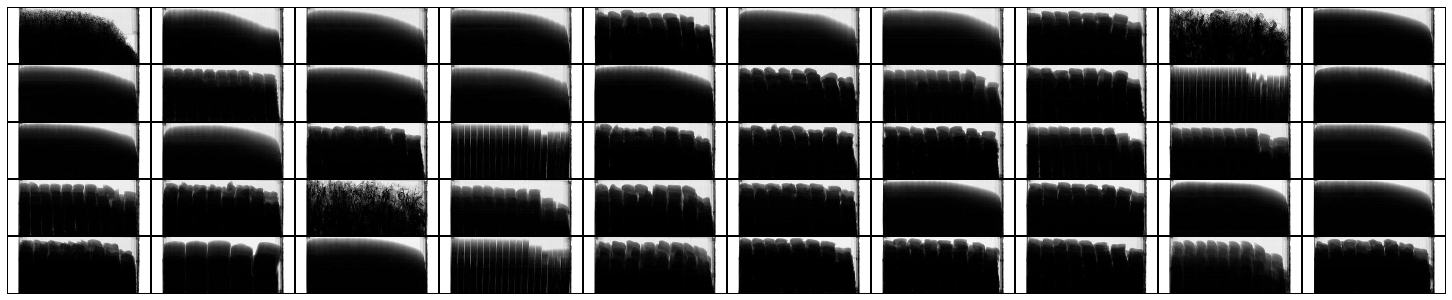

In [22]:
fig, axes = plt.subplots(nrows=5, ncols=10, sharex=True, sharey=True, figsize=(20,4))
ind=0
for row in axes:
    for ax in row:
        img = X[order[ind]]
        ax.imshow(img.reshape((size[1], size[0])), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ind+=1

fig.tight_layout(pad=0.1)

 ## Salvar modelo plano

In [12]:
model.save('plano/conteineresencoder.tflearn')

INFO:tensorflow:/home/ivan/Estudo/NanoDegree/Buscador/plano/conteineresencoder.tflearn is not in all_model_checkpoint_paths. Manually adding it.


 ## Salvar modelo convolucional

In [23]:
saver = tf.train.Saver()
save_path = saver.save(sess, "conv/modelconv.ckpt")
print("Model saved in file: %s" % save_path)

Model saved in file: conv/modelconv.ckpt


 ## Salvar índice de imagens comprimidas

In [24]:
import pickle
with open('compressedconv.pkl', 'wb') as output:
        pickle.dump(compressed, output, pickle.HIGHEST_PROTOCOL)

# Check-point --- para uso em aplicações proceder conforme abaixo

In [1]:
from __future__ import division, print_function, absolute_import
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

size = (256, 120)
inputsize = size[0]*size[1]
home = '/home/ivan/Área de Trabalho/ajna/amostras/stamps/'
dest = os.path.join(home, 'resize/')

In [2]:
### Lista de índices
with open('compressed.pkl', 'rb') as input:
        compressed = pickle.load(input)

In [3]:
###Model Fully
import tflearn
from modelfully import *
model, encoder, decoder = modelfully1(inputsize)
model.load('plano/conteineresencoder.tflearn')
encoding_model = tflearn.DNN(encoder, session=model.session)

In [4]:
# Apenas caso compressed não seja recuperado de arquivo ou BD
#compressed = encoding_model.predict(X) 
listSearch = np.array(compressed, dtype=np.float32)
#listSearchBinaryCode = listaBinaria(listSearch)
print(listSearch)
print(listSearch.shape)

[[  4.8979311   -1.71843851   0.6896643  ...,   5.0415926    0.91827202
    0.74138951]
 [ 10.28980637  -5.08350325   0.13227902 ...,  10.27590561  -0.99783969
    1.10521019]
 [  7.21124077   0.81402886  -1.71107817 ...,   4.16334248   6.5722127
    0.07531053]
 ..., 
 [  7.44124365  -9.16010857 -18.22451401 ...,  12.17253876  -1.76780021
   16.63276863]
 [  4.28486919  -3.61073542  -0.98695868 ...,   5.17890978  -3.71957874
   -0.52893442]
 [  1.72815633   0.69283301  -0.60162765 ...,  11.49221802   1.32945895
    0.8522715 ]]
(652, 200)


In [5]:
##Busca model fully
from indexfunctions import *

# Aqui, na prática, a aplicação irá receber uma imagem e a transformar para procura
im = Image.open(os.path.join(dest,'CARU9773334.jpg'))
imagem = np.asarray(im).reshape(inputsize) / 255
#print(imagem)
encode_code =  np.array(encoding_model.predict([imagem]), dtype=np.float32)
#print(encode_code)
print(encode_code.shape)
order = montaListaOrdenadaEuclidean(listSearch, encode_code, encoding_model)
#order = montaListaOrdenadaHamming(listSearchBinaryCode, encode_code)
order

(1, 200)


array([458, 460, 514, 554, 375, 506, 568, 122, 404, 186, 479, 249, 537,
       266, 524, 137, 632, 543, 214,  58, 204, 418, 410, 578, 153, 339,
       157,   3, 576, 574, 456,  47, 275, 481, 286, 316,   2, 114, 320,
       559, 143, 120, 141, 211, 212,  60, 296, 421, 228,  17, 318, 154,
       573, 372, 584, 240, 281, 298, 505, 307,  41, 448, 553,  21, 171,
       626, 247, 621, 500, 390, 400, 210, 236, 459, 173, 638, 650, 181,
       571, 586,  32, 264,  13, 335,   0, 557, 373, 207,  76,  33, 341,
       422, 360, 486, 605,  52, 507,  61, 338, 273, 234, 463, 107, 645,
       356, 256,  67, 115,  20,  40, 350, 265, 611, 544,  35,  70, 521,
       426,  45, 497, 490,  96, 209, 221,  74, 475, 125, 131, 347, 532,
       357, 321,  99, 142, 496, 613, 105, 469, 358, 359, 615, 471, 598,
        53, 651, 343, 325, 424, 215, 624, 292,  92,  79, 545,  59, 290,
       600, 177, 306, 589,  81, 368, 640,  39, 461, 627, 518,  91,  38,
        43,  77, 580,  78, 134, 453,  54, 201, 349, 591, 525, 22

In [ ]:
###Model Convolutional
import tensorflow as tf
from modelconv import *
encoded, decoded, loss, cost, opt = modelconv1(size)
saver = tf.train.Saver()

with tf.Session() as sess:
  # Restore variables from disk.
  saver.restore(sess, "conv/modelconv.ckpt")


 ## Testar imagens A, B, C, D, E, F, G

(7, 30720)
imgnotebook/exemplovazio.png
imgnotebook/exemplocaixa1.png
imgnotebook/exemplocaixa1espelhado.png
imgnotebook/exemplocaixa2.png
imgnotebook/exemplocirculoespelhado.png
imgnotebook/exemplocaixa2espelhado.png
imgnotebook/exemplocirculo.png


/usr/lib/python3/dist-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


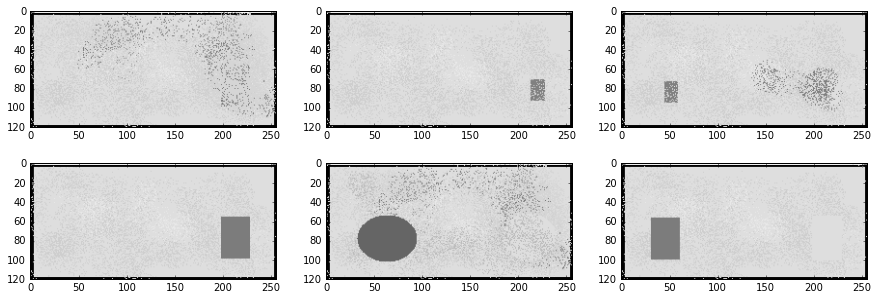

In [26]:
%matplotlib inline
import glob
inputsize = size[0]*size[1]

numarquivos = len([name for name in os.listdir('imgnotebook') if name.endswith('png')])
X = np.ndarray(shape=(numarquivos, inputsize), dtype=np.float32)
print(X.shape)

cont = 0
for file in glob.glob(os.path.join('imgnotebook','*.png')):
    print(file)
    im = Image.open(file).convert('L')
    X[cont] = np.asarray(im).reshape(inputsize)
    cont +=1

f, a = plt.subplots(2, 3, figsize=(15, 5))
for i in range(3):
    a[0][i].imshow(np.reshape(X[i], (size[1], size[0])), cmap='gray')
    a[1][i].imshow(np.reshape(X[i+3], (size[1], size[0])), cmap='gray')
f.show()
plt.draw()

In [28]:
### Para realizar testes com a rede plana
compressed = encoding_model.predict(X) 
listSearch = np.array(compressed, dtype=np.float32)
#listSearchBinaryCode = listaBinaria(listSearch)
print(listSearch)
print(listSearch.shape)

[[ -5.23029175e+02   4.08600983e+02  -1.68050049e+02 ...,  -4.00533643e+03
    2.30781177e+03  -7.31271790e+02]
 [ -5.49579834e+02   3.26271515e+02  -2.44342087e+02 ...,  -4.07306104e+03
    2.08900391e+03  -7.85239502e+02]
 [ -5.08350311e+02   4.20053650e+02  -2.62586121e+02 ...,  -3.88084497e+03
    2.22534888e+03  -5.99221985e+02]
 ..., 
 [ -1.07302551e+03  -2.54709351e+02  -8.76599487e+02 ...,  -3.21856982e+03
    1.26100732e+03  -1.39939102e+02]
 [ -4.10888916e+02   3.02861511e+02  -7.77277893e+02 ...,  -3.50393018e+03
    1.63883240e+03  -4.44011505e+02]
 [ -8.64821594e+02   1.32355945e+03   3.74686766e+00 ...,  -3.36032324e+03
    3.15531421e+03  -1.21568994e+03]]
(7, 200)


In [31]:
### Para realizar testes com a rede convolucional
imgSearch = X.reshape((-1, size[1], size[0], 1))
listSearch = np.array(sess.run([encoded], feed_dict={inputs_: imgSearch})).reshape(-1, 256)

print(listSearch)
print(listSearch.shape)

[[  0.           0.          52.77127838 ...,   0.           0.
   10.03362274]
 [  0.           0.          52.70506668 ...,   0.           0.           8.9855299 ]
 [  0.           0.          52.70506668 ...,   0.           0.
    8.85794735]
 ..., 
 [  0.           0.          52.99953842 ...,   0.           0.           9.6234951 ]
 [  0.           0.          52.59076309 ...,   0.           0.
    9.08255959]
 [  0.           0.          52.77127838 ...,   0.           0.
    6.57945108]]
(7, 256)


(7, 256)
[1 2 3 5 0 6 4]


/usr/lib/python3/dist-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


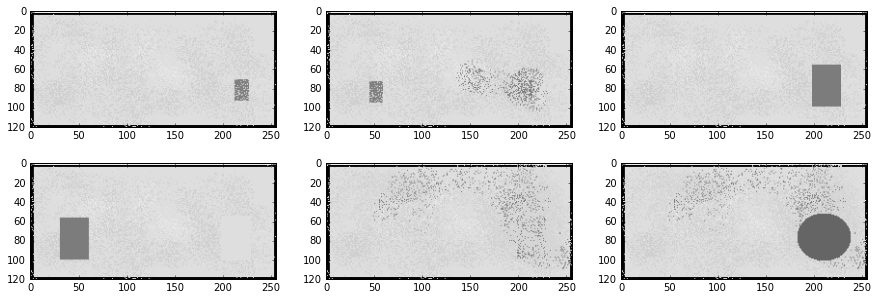

In [32]:
from indexfunctions import *

def testeCaixas(pX, plano=True):
    if plano:
        imgSearch = encoding_model.predict(pX)
    else:
        img = pX.reshape((-1, size[1], size[0], 1))
        imgSearch = np.array(sess.run([encoded], feed_dict={inputs_: img})).reshape(-1, 256)
    
    print(listSearch.shape)
    order = montaListaOrdenadaEuclidean(listSearch, imgSearch) 
    print(order)
    Xorder = X[order]
    f, a = plt.subplots(2, 3, figsize=(15, 5))
    for i in range(3):
        a[0][i].imshow(np.reshape(Xorder[i], (size[1], size[0])), cmap='gray')
        a[1][i].imshow(np.reshape(Xorder[i+3], (size[1], size[0])), cmap='gray')
    f.show()
    plt.draw()
    
Xloc = X[1]  # Caixa pequena esquerda
testeCaixas(Xloc, False)

[4 5 2 0 1 3 6]


/usr/lib/python3/dist-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


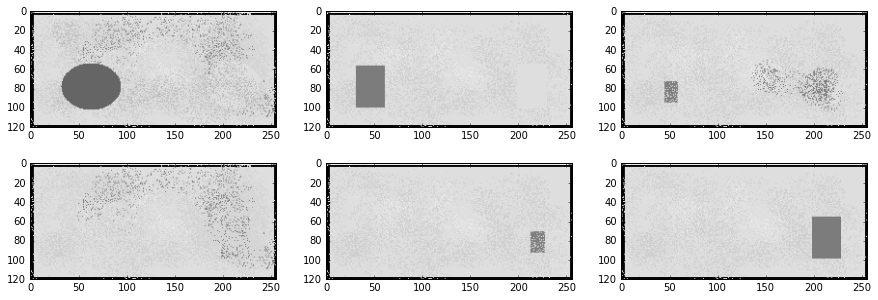

In [34]:
order = montaListaOrdenadaEuclidean(listSearch, X[4], encoding_model) # Círculo esquerda
print(order)
Xorder = X[order]
f, a = plt.subplots(2, 3, figsize=(15, 5))
for i in range(3):
    a[0][i].imshow(np.reshape(Xorder[i], (size[1], size[0])), cmap='gray')
    a[1][i].imshow(np.reshape(Xorder[i+3], (size[1], size[0])), cmap='gray')
f.show()
plt.draw()

(7, 256)
[3 1 2 5 0 6 4]


/usr/lib/python3/dist-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


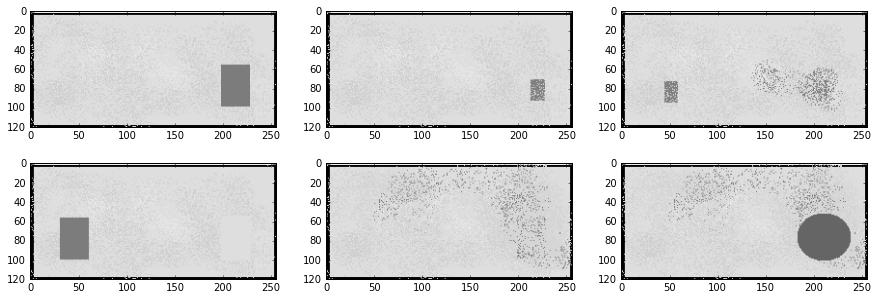

In [35]:
Xloc = X[3]  # Caixa pequena esquerda
testeCaixas(Xloc, False)

[6 3 1 0 2 5 4]


/usr/lib/python3/dist-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


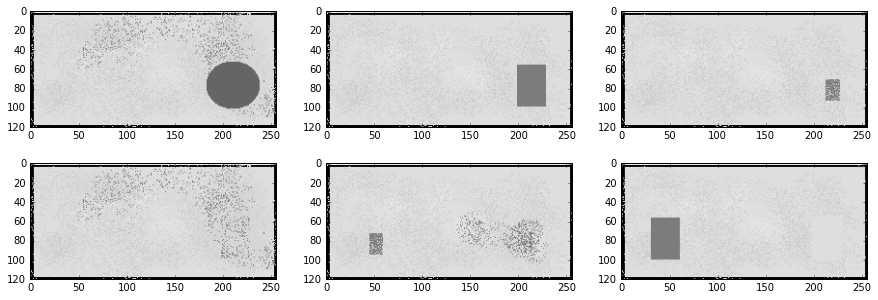

In [36]:
order = montaListaOrdenadaEuclidean(listSearch, X[6], encoding_model) # Círculo esquerda
print(order)
Xorder = X[order]
f, a = plt.subplots(2, 3, figsize=(15, 5))
for i in range(3):
    a[0][i].imshow(np.reshape(Xorder[i], (size[1], size[0])), cmap='gray')
    a[1][i].imshow(np.reshape(Xorder[i+3], (size[1], size[0])), cmap='gray')
f.show()
plt.draw()

 ## Os testes com as imagens fabricadas foram muito bem, conforme acima, parece que o Encoder foi capaz de aprender volume, formato, distribuição. Mas, como previsto, parece que a posição dos objetos determina o resultado. Testar com convolucional para ver se consegue ficar independente da posição dos objetos.

 ## Teste com convolucional em 30/06/2017 não apresentou resultados melhores. Testar treinamento de ambas as redes com mais dados e com encoders ligeiramente maiores no futuro.